В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [60]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [61]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [62]:
class NeuralNet:
    
    def __init__(self, layers_sizes, normalize = True, learning_rate = 0.01, num_iter = 15000, costs_iters=300, tol=1e-7):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.layers_sizes = layers_sizes
        self.tol = tol
        self.layers = len(layers_sizes) + 1
        self.costs_iters = costs_iters
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __sigmoid_derivative(self, A):
        return np.multiply(A, 1 - A)
    
    def __initialize_parameters(self):
        W, b = [], []
        
        for l in range(1,self.layers+1):
            W_l = np.random.randn(self.layers_sizes[l], self.layers_sizes[l-1]) * 0.01
            b_l = np.zeros((self.layers_sizes[l], 1))
            W.append(W_l)
            b.append(b_l)
        
        self.parameters = {"W" : W, "b" : b}
        
        for key in self.parameters:
            for key_i,i in zip(self.parameters[key],range(len(self.parameters[key]))):
                print("{}{}: {}".format(key,i+1,key_i.shape))
       
    def __forward_propagation(self, X):            
        W = self.parameters["W"]
        b = self.parameters["b"]
        Z, A = [], [] 

        A.append(X)
        for l in range(0,self.layers):
            Z_l = np.dot(W[l],A[l]) + b[l]
            A_l = self.__sigmoid(Z_l)
            Z.append(Z_l)
            A.append(A_l)
        
        cache = (Z,A)
        return A[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        
        W = self.parameters["W"]
        b = self.parameters["b"]
        (Z,A) = cache
        
        dZ, dW, db = [], [], []
        
        dZ_l = A[-1] - Y
        dW_l = 1. / m * np.dot(dZ_l, A[-2].T)
        db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
        
        dZ.insert(0,dZ_l)
        dW.insert(0,dW_l)
        db.insert(0,db_l)
        
        for l in range(self.layers-1,0,-1):
            dA_l = np.dot(W[l].T,dZ_l)
            dZ_l = np.multiply(dA_l, self.__sigmoid_derivative(A[l]))
            dW_l = 1. / m * np.dot(dZ_l, A[l-1].T)
            db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
            dZ.insert(0,dZ_l)
            dW.insert(0,dW_l)
            db.insert(0,db_l)
        
        grads = {"dZ":dZ,"dW":dW,"db":db}
        return grads
  
    
    def __update_parameters(self, grads):        
        W = self.parameters["W"]
        b = self.parameters["b"]
        dW = grads["dW"]
        db = grads["db"]
    
        for l in range(0,len(W)):
            W[l] = W[l] - self.learning_rate * dW[l]
            b[l] = b[l] - self.learning_rate * db[l]
            
        self.parameters["W"] = W
        self.parameters["b"] = b

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        costs_imp = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.layers_sizes.insert(0,n_x)
        self.layers_sizes.append(1);
        
        self.__initialize_parameters()

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            
            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
            
            costs_imp.append(cost)
            if i > self.costs_iters:
                len_imp = len(costs_imp)-1
                if abs(costs_imp[len_imp] - costs_imp[len_imp-self.costs_iters]) < self.tol:
                    print("Stop iteration: {}".format(i))
                    break;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [82]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X1, Y1 = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


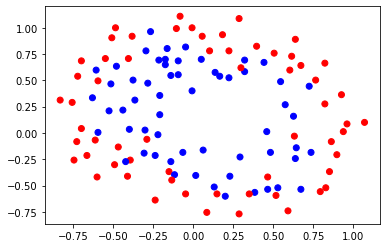

In [83]:
plot_data(X1, Y1)

In [84]:
cls1 = NeuralNet(layers_sizes=[70,60], normalize = True, learning_rate = 0.5, num_iter = 15000, tol=1e-8, costs_iters=500)

W1: (70, 2)
W2: (60, 70)
W3: (1, 60)
b1: (70, 1)
b2: (60, 1)
b3: (1, 1)
0-th iteration: 0.6933760941552787
1000-th iteration: 0.6930028118284993
2000-th iteration: 0.6930022399758523
3000-th iteration: 0.6930014233382816
4000-th iteration: 0.693000142537433
5000-th iteration: 0.6929979485275319
6000-th iteration: 0.692993800388106
7000-th iteration: 0.6929848896995696
8000-th iteration: 0.692961878432557
9000-th iteration: 0.6928822708018041
10000-th iteration: 0.6924369735087
11000-th iteration: 0.6904971119909098
12000-th iteration: 0.6899561083356711
13000-th iteration: 0.689078180323412
14000-th iteration: 0.6703950136380457


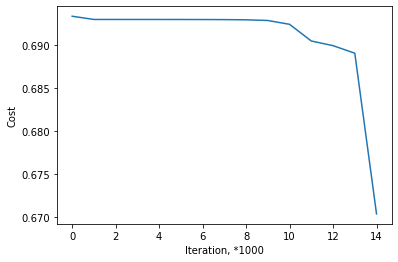

In [85]:
cls1.fit(X1, Y1.values.reshape((df.shape[0], 1)))

In [86]:
print(cls1.parameters)

{'W': [array([[-3.21510252e-01, -2.64316558e-01],
       [-9.68591623e-01, -7.41825422e-01],
       [-1.29441934e-01, -7.72544933e-02],
       [ 2.44864782e-01,  2.30498519e-01],
       [-4.88251268e-01, -3.99451247e-01],
       [-3.02059214e-01, -2.38784579e-01],
       [ 4.01046272e-01,  3.88939888e-01],
       [-5.69577783e-02, -6.72085560e-05],
       [-6.01721807e-04,  3.57922980e-02],
       [ 2.75069563e-01,  2.77488984e-01],
       [ 4.25742060e-01,  4.17458458e-01],
       [-2.05670461e-01, -1.69508307e-01],
       [-2.04817782e-01, -1.60197770e-01],
       [ 6.28701331e-01,  5.76256624e-01],
       [ 8.19256691e-02,  9.23199566e-02],
       [ 1.47757110e-01,  1.59672723e-01],
       [-5.35295558e-01, -4.53258721e-01],
       [-2.32897892e-01, -1.94352062e-01],
       [-2.92375593e-01, -2.32767535e-01],
       [-9.48741232e-01, -7.32551886e-01],
       [-1.18317566e-01, -7.01045045e-02],
       [-4.29572412e-01, -3.59638648e-01],
       [-1.11252577e-01, -1.08502485e-01],
    

In [87]:
Y1_prob = cls1.predict_proba(X1)
Y1_prob

array([[0.66584346, 0.33415654],
       [0.40050345, 0.59949655],
       [0.3916345 , 0.6083655 ],
       [0.57581886, 0.42418114],
       [0.27290632, 0.72709368],
       [0.48051129, 0.51948871],
       [0.24266455, 0.75733545],
       [0.75769136, 0.24230864],
       [0.66594029, 0.33405971],
       [0.51657567, 0.48342433],
       [0.62578624, 0.37421376],
       [0.33726225, 0.66273775],
       [0.18797592, 0.81202408],
       [0.39930089, 0.60069911],
       [0.46221723, 0.53778277],
       [0.64222118, 0.35777882],
       [0.48054845, 0.51945155],
       [0.75859816, 0.24140184],
       [0.48596408, 0.51403592],
       [0.46149241, 0.53850759],
       [0.78042843, 0.21957157],
       [0.46506056, 0.53493944],
       [0.4786705 , 0.5213295 ],
       [0.39904356, 0.60095644],
       [0.61860283, 0.38139717],
       [0.76862633, 0.23137367],
       [0.31252669, 0.68747331],
       [0.78755619, 0.21244381],
       [0.47560715, 0.52439285],
       [0.60127019, 0.39872981],
       [0.

In [88]:
Y1_hat = cls1.predict(X1)
Y1_hat

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1])

In [89]:
accuracy_score(Y1, Y1_hat)

0.6864406779661016

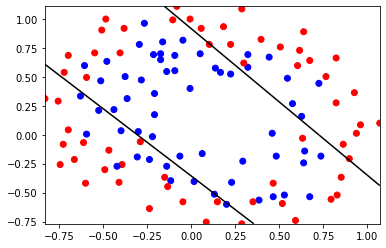

In [90]:
plot_data(X1, Y1)
plot_surface(cls1, X1[:, 0], X1[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [40]:
from sklearn.neural_network import MLPClassifier
clf1 = MLPClassifier(hidden_layer_sizes = (20,20), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [41]:
clf1.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(20, 20), learning_rate_init=0.01,
              max_iter=10000, solver='sgd')

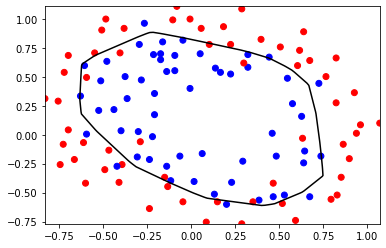

In [42]:
plot_data(X, Y)
plot_surface(clf1, X[:, 0], X[:, 1])

In [44]:
accuracy_score(Y, clf1.predict(X))

0.864406779661017

In [46]:
clf1.n_iter_

822

# Датасет 2 

In [21]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column]#reshape((df.shape[0], 1))
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(100, 2), y=(100,)


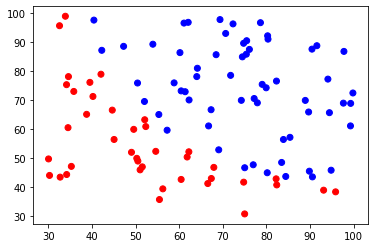

In [22]:
plot_data(X, Y)

In [23]:
cls = NeuralNet(layers_sizes = [5,5], normalize = True, learning_rate = 0.1, num_iter = 12001, tol = 1e-7, costs_iters=500)

Layers: 3


W1: (5, 2)
W2: (5, 5)
W3: (1, 5)
b1: (5, 1)
b2: (5, 1)
b3: (1, 1)
0-th iteration: 0.6925847318501446
1000-th iteration: 0.6730073972118618
2000-th iteration: 0.6729977752086765
3000-th iteration: 0.6729722870110233
4000-th iteration: 0.6728924947863166
5000-th iteration: 0.6725544638758308
6000-th iteration: 0.6692673706065395
7000-th iteration: 0.4002916516900992
8000-th iteration: 0.22877119916139638
9000-th iteration: 0.20523439955507017
10000-th iteration: 0.14924060314963078
11000-th iteration: 0.10849435209796489
12000-th iteration: 0.08223530730653249


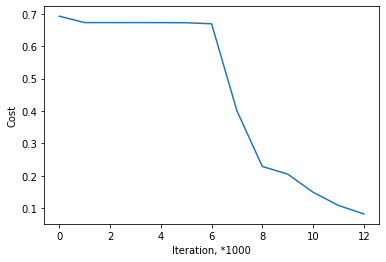

In [24]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [25]:
print(cls.parameters)

{'W': [array([[ 1.57460199,  0.9781168 ],
       [ 0.67856351,  2.53282381],
       [-3.82010806, -1.06072973],
       [ 0.05082486,  0.05429238],
       [-0.67598941, -2.69291453]]), array([[ 0.65787353,  1.06807766, -2.00351404, -0.09600768, -1.4352322 ],
       [ 1.18967185,  2.03926686, -3.60827663, -0.02143039, -2.36510158],
       [ 1.0042308 ,  1.66985578, -2.99449514, -0.04857657, -2.01303319],
       [ 0.9790071 ,  1.6079975 , -2.90703721, -0.06219435, -1.97786179],
       [ 0.54792683,  0.89993558, -1.73426961, -0.12853885, -1.28028872]]), array([[1.9765088 , 4.66123689, 3.59560955, 3.45300237, 1.56515445]])], 'b': [array([[ 0.48331987],
       [ 1.94321473],
       [-2.89416368],
       [ 0.00665105],
       [-2.16665042]]), array([[-0.34180342],
       [-0.22751841],
       [-0.26476208],
       [-0.25604657],
       [-0.34777637]]), array([[-6.14368469]])]}


In [26]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[3.98776642e-02, 9.60122336e-01],
       [2.57111704e-03, 9.97428883e-01],
       [2.43122014e-02, 9.75687799e-01],
       [9.98935690e-01, 1.06430994e-03],
       [9.99243550e-01, 7.56449904e-04],
       [5.33191868e-03, 9.94668081e-01],
       [9.99211513e-01, 7.88486816e-04],
       [5.26276647e-01, 4.73723353e-01],
       [9.99336241e-01, 6.63759026e-04],
       [6.28596824e-01, 3.71403176e-01],
       [4.87812644e-01, 5.12187356e-01],
       [1.65622607e-02, 9.83437739e-01],
       [9.99294118e-01, 7.05881734e-04],
       [9.99339851e-01, 6.60149110e-04],
       [7.49054845e-02, 9.25094516e-01],
       [9.98157639e-01, 1.84236053e-03],
       [8.63904409e-01, 1.36095591e-01],
       [1.49616321e-01, 8.50383679e-01],
       [9.99326301e-01, 6.73699429e-04],
       [7.49014675e-01, 2.50985325e-01],
       [3.65634687e-02, 9.63436531e-01],
       [9.99142818e-01, 8.57182207e-04],
       [4.06757070e-03, 9.95932429e-01],
       [2.60274543e-03, 9.97397255e-01],
       [9.990249

In [27]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [28]:
accuracy_score(Y, Y_hat)

1.0

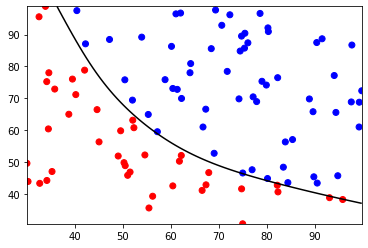

In [29]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])